In [2]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
import mne
np.random.seed(42)
%load_ext autoreload
%autoreload 2

# ERPs

In [3]:
data_dir = './data'
exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='wm')
erp = decode_eeg.ERP(exp)

In [71]:
xdata_all, ydata_all = erp.load_all_eeg(xdata_var_name = 'wm_xdata', ydata_var_name = 'wm_ydata')

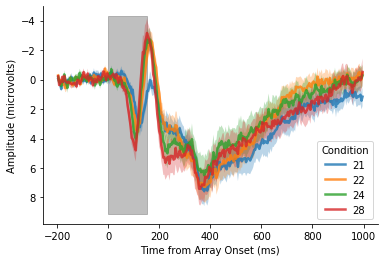

In [4]:
erp.plot_conditions(xdata_all,ydata_all,electrode_subset = ('O','P'),conditions = [21,22,24,28])

# Alpha Power ERPs

In [6]:
exp = decode_eeg.Experiment('fukuda_woodman', data_dir, test=False, regex='wm')
erp = decode_eeg.ERP(exp)

xdata_all = np.empty((exp.nsub),dtype='object')
ydata_all = np.empty((exp.nsub),dtype='object')
for isub in range(exp.nsub):
     xdata,ydata= exp.load_eeg(isub, xdata_var_name='wm_xdata',ydata_var_name='wm_ydata')
     xdata = calc_power(xdata,exp,8,13)
     xdata = exp.trim_epochs(xdata,start=-200,end=1000)
     xdata_all[isub], ydata_all[isub] = xdata, ydata

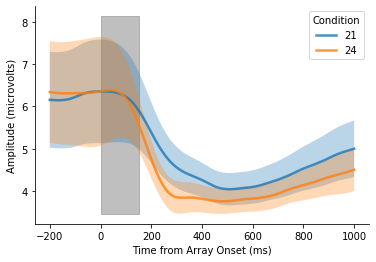

In [25]:
erp.plot_conditions(xdata_all,ydata_all,electrode_subset = ('O'),conditions = [21,24])

# WM Classification

In [158]:
time_window = 30
time_step = 30
trial_average = 10
n_splits = 30
group_dict = {0:[21],1:[22],2:[24],3:[28]}
wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=4)

In [159]:
for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub,xdata_var_name='wm_xdata',ydata_var_name='wm_ydata')
    xdata = add_power(xdata,exp,lower=8,upper=12)
    xdata = exp.trim_epochs(xdata,-200,1000)
    xdata,ydata = wrangl.setup_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [160]:
interp = decode_eeg.Interpreter(clfr)

Saving output\figures\acc20201115_2355.pdf
Saving output\figures\acc20201115_2355.png


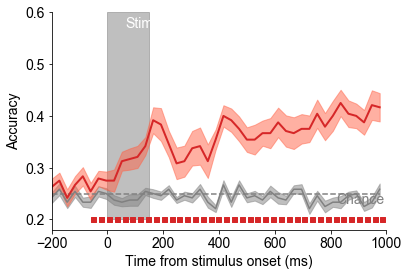

In [162]:
interp.plot_acc(significance_testing=1,savefig=1,ylim=[.18,.6])

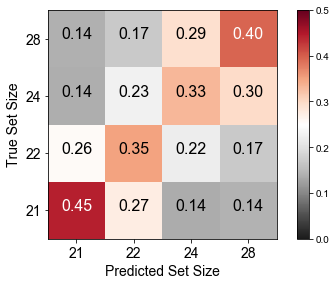

In [163]:
interp.plot_conf_mat(lower=.0,upper=.5,savefig=0)

In [5]:
def calc_power(xdata,exp,lower=None,upper=None,lower_upper_list=None):
    info = mne.create_info(list(exp.info['electrode_labels']),int(exp.info['sampling_rate']),'eeg')
    eeg = mne.EpochsArray(xdata,info=info,verbose=False)
    if lower_upper_list:
        for bands in lower_upper_list:
            copy_eeg = eeg.copy()
            copy_eeg.filter(bands[0],bands[1],n_jobs=1,l_trans_bandwidth=1,h_trans_bandwidth=1,verbose=False)
            copy_eeg.apply_hilbert(envelope=True,verbose=False)
            xdata = np.concatenate((xdata,copy_eeg.get_data()),1)
    else:
        eeg.filter(lower,upper,n_jobs=1,l_trans_bandwidth=1,h_trans_bandwidth=1,verbose=False)
        eeg.apply_hilbert(envelope=True,verbose=False)
        xdata = eeg.get_data()
    return xdata